
<center> <img src="figures/logos.png" style="width:450px">

<center> <font size="+2"> Tree Sequence Fundamentals: introduction to tskit, The Tree Sequence Toolkit </font>
<center> <font size="+1"> Anthony Wilder Wohns </font>
<center> <font size="+1"> Big Data Institute/Department of Statistics, University of Oxford </font>

Datasets of millions of genomes demand highly compact data structures and an efficient analysis toolkit.


Tree sequences and $\texttt{tskit}$ are our answer to this challenge.


$\texttt{tskit}$ includes a suite of tools for calculating common statistics of interest from tree sequences. Tree sequences can be simulated using $\texttt{msprime}$ and $\texttt{SLiM}$ are scalable coalescent and forwards time simulators. Finally, we can infer tree sequences from millions of samples using $\texttt{tsinfer}$.


We'll use the Python API for $\texttt{tskit}$ and $\texttt{msprime}$ to see how these tools work, how efficient they are, and how they can be used to answer questions you are interested in.

1. [tskit Python API](#ts)
2. [Tree Sequence Statistics</span>](#statistics)
3. [msprime Simulations</span>](#msprime)

In [1]:
import tsinfer
import tskit
import msprime
import io
import numpy as np
import matplotlib.pyplot as plt
import pysvg
import json
from IPython.display import SVG, display, HTML
import scipy
import seaborn as sns
import pandas as pd

nodes = io.StringIO("""\
id  is_sample   population  individual  time    metadata
0   1   0   -1  0.00000000000000    
1   1   0   -1  0.00000000000000    
2   1   0   -1  0.00000000000000    
3   1   0   -1  0.00000000000000    
4   1   0   -1  0.00000000000000    
5   1   0   -1  0.00000000000000    
6   0   0   -1  0.5   
7   0   0   -1  0.5   
8   0   0   -1  0.75 
9   0   0   -1  1.5
10  0   0   -1  1.5
11  0   0   -1  1.75
12  0   0   -1  2.5 
        """)
edges = io.StringIO("""\
id  left        right       parent  child
0   0.00000000  50.00000000 7   0
1   0.00000000  50.00000000 7   1
2   0.00000000  15          11   2
3   0.00000000  15          8   3
4   0.00000000  15          12   11
5   0.00000000  15          11   9
6   0.00000000  50          8   4
7   0.00000000  50          9   5
8   0.00000000  50          9  8
9   15  30          6  2
10   15  30          6  3
11   15  50          12  9
12  30  50 10  3
13  30  50 12  10
14  30  50 8  2
15  30  50 10  7
15  0  30 12  7
15  15  30 8  6
""")
sites = io.StringIO("""\
id  position    ancestral_state metadata
0   6 0   
1   12 0   
2   20 0 
3   40 0 
""")
mutations = io.StringIO("""\
id  site    node    derived_state   parent  metadata
0   0   0   1   -1  
1   1   11  1   -1  
2   2   8  1   -1 
3   3   10  1   -1 
""")
treeseq_example = tskit.load_text(nodes, edges, sites = sites, mutations = mutations, sequence_length=50, strict=False)


treeseq_example.dump('data/tree_sequence_example.trees')

# 1. [tskit Python API](#ts)


Let's get hands on with the python API as we familiarize ourselves with tree sequences. Note that a comprehensive documentation can be found at https://tskit.readthedocs.io/<br>


We'll start with the top level $\texttt{TreeSequence}$ class. 

In [2]:
import tskit
# Let's load the example we were just looking at as a tree sequence
treeseq_example = tskit.load("data/tree_sequence_example.trees")

Let's look again at the trees from the example above. The simpest way to do this is to print call the draw_svg() function.

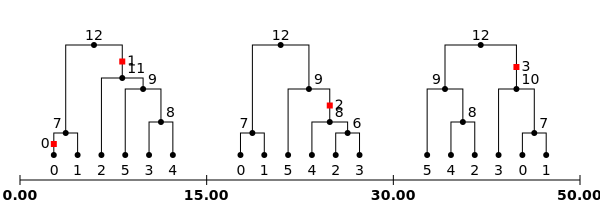

In [3]:
SVG(treeseq_example.draw_svg())

This is the example we've been working with.

The `tskit` library allow us to use tree sequence objects in Python; these have specific properties and can also be queried using various methods. For example, we can easily show the number of trees in a tree sequence as follows 

In [17]:
treeseq_example.num_trees

3

We can also show the number of nodes, mutations and edges in the tree sequence

In [18]:
treeseq_example.num_nodes

13

In [19]:
treeseq_example.num_edges

18

In [20]:
treeseq_example.num_mutations

4

We can get the same information for each individual tree. All we need to do is iterate over the trees again

In [21]:
for tree in treeseq_example.trees():
    print('Tree', tree.index,'has:', tree.num_mutations, 'mutation(s)')


Tree 0 has: 2 mutation(s)
Tree 1 has: 1 mutation(s)
Tree 2 has: 1 mutation(s)


# Tables: The underlying infrastructure of a Tree Sequence
We'll understand how tree sequences are stored before getting hands-on with the API again 


![SegmentLocal](figures/mutations_gif.gif "segment")

![SegmentLocal](figures/edges_gif.gif "segment")

![SegmentLocal](figures/nodes_gif.gif "segment")

Since a tree sequence object is entirely specified by tables, these provide access to the internal representation of a tree sequence object. Below is a simple example of inspecting tables.

In [22]:
treeseq_example.tables.nodes

id,flags,population,individual,time,metadata
0,1,0,-1,0.00000000000000,
1,1,0,-1,0.00000000000000,
2,1,0,-1,0.00000000000000,
3,1,0,-1,0.00000000000000,
4,1,0,-1,0.00000000000000,
5,1,0,-1,0.00000000000000,
6,0,0,-1,0.50000000000000,
7,0,0,-1,0.50000000000000,
8,0,0,-1,0.75000000000000,
9,0,0,-1,1.50000000000000,


In [23]:
treeseq_example.tables.edges

id,left,right,parent,child,metadata
0,15.00000000,30.00000000,6,2,
1,15.00000000,30.00000000,6,3,
2,0.00000000,50.00000000,7,0,
3,0.00000000,50.00000000,7,1,
4,30.00000000,50.00000000,8,2,
5,0.00000000,15.00000000,8,3,
6,0.00000000,50.00000000,8,4,
7,15.00000000,30.00000000,8,6,
8,0.00000000,50.00000000,9,5,
9,0.00000000,50.00000000,9,8,


In [24]:
treeseq_example.tables.mutations

id,site,node,derived_state,parent,metadata
0,0,0,1,-1,
1,1,11,1,-1,
2,2,8,1,-1,
3,3,10,1,-1,


The data in a table is itself stored as numpy arrays:

In [25]:
treeseq_example.tables.nodes.time

array([0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.5 , 0.5 , 0.75, 1.5 , 1.5 ,
       1.75, 2.5 ])

We can also use the $\texttt{tskit}$ C API to work with tree sequences. Here we show a snippet from a Wright-Fisher simulator:

```C
child = tsk_node_table_add_row(&tables->nodes, 
   0, t, TSK_NULL, TSK_NULL, NULL, 0);
left_parent = parents[gsl_rng_uniform_int(rng, N)];
right_parent = parents[gsl_rng_uniform_int(rng, N)];
breakpoint = gsl_rng_uniform(rng);
tsk_edge_table_add_row(&tables->edges, 0, breakpoint, left_parent, child);
tsk_edge_table_add_row(&tables->edges, breakpoint, 1, right_parent, child);
```

# 2. Tree Sequence Statistics
1. [tskit Python API](#ts)
2. [Tree Sequence Statistics</span>](#statistics)
3. [msprime Simulations</span>](#msprime)


We can easily calculate a variety of statistics with tskit

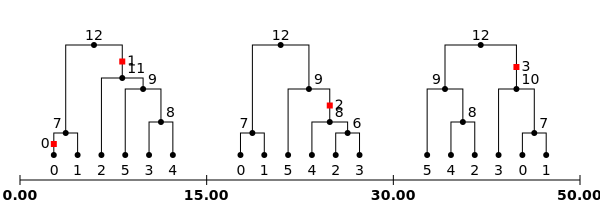

In [26]:
SVG(treeseq_example.draw_svg())

In [27]:
treeseq_example.allele_frequency_spectrum(span_normalise=False, polarised=True)

array([0., 1., 0., 2., 1., 0., 0.])

In [28]:
treeseq_example.pairwise_diversity()

2.066666666666667

For a complete list of statistics implemented in tskit, see: https://tskit.readthedocs.io/en/latest/stats.html

# Parsimony

The Tree.map_mutations() method finds a parsimonious explanation for a set of discrete character observations on the samples in a tree using classical phylogenetic algorithms.

Ancestral state =  red
Mutation: node = 5 derived_state = green
Mutation: node = 4 derived_state = blue


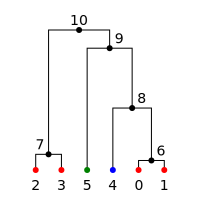

In [29]:
tree = msprime.simulate(6, random_seed=42).first()
alleles = ["red", "blue", "green"]
genotypes = [0, 0, 0, 0, 1, 2]
node_colours = {j: alleles[g] for j, g in enumerate(genotypes)}
ancestral_state, mutations = tree.map_mutations(genotypes, alleles)
print("Ancestral state = ", ancestral_state)
for mut in mutations:
    print(f"Mutation: node = {mut.node} derived_state = {mut.derived_state}")
SVG(tree.draw(node_colours=node_colours))

So, the algorithm has concluded, quite reasonably, that the most parsimonious description of this state (i.e. the fewest number of transitions) is that the ancestral state is red and there was a mutation to blue and green over nodes 4 and 5.

## Genealogical Nearest Neighbours
A useful, topology-based metric for understanding population level relationships from a tree sequence is genealogical nearest neighbours. 


Given K sets of reference nodes (e.g., the samples for each of the 15 populations of clonal *vivax* samples), the GNN statistic for a specific node is a K-vector describing the proportion of its immediate neighbours within the tree from each of these reference sets. <br>
Here is an example from the small example we've been working with.

In [ ]:
# Define a reference set for each individual
reference_sets = [[0,1],[2,3],[4,5]]
pd.DataFrame(treeseq_example.genealogical_nearest_neighbours(treeseq_example.samples(),reference_sets),
             columns=["Individual_A","Individual_B","Individual_C"])


<img src="figures/original_trees.png" width=700px>


Think of this as looking at the most recent ancestor of each sample and determining what population the other daughter sample(s) of that node came from.  
<br>



# 3. msprime Simulations

1. [tskit Python API](#ts)
2. [Tree Sequence Statistics</span>](#statistics)
3. [msprime Simulations</span>](#msprime)

Tree sequences can be simulated using either a coalescent simulator, $\texttt{msprime}$, or a fowards time simulator, $\texttt{SLiM}$.

## Reverse-time simulations with $\texttt{msprime}$
The $\texttt{msprime}$ program is an efficient reimplementation of Hudson's $\texttt{ms}$ simulator which outputs coalescent trees using the tree sequence format. The easiest way to use it is through the Python API, which is well documented at https://msprime.readthedocs.io/en/stable/api.html. The citation is as follows: <br> Kelleher, Jerome, Alison M. Etheridge, and Gilean McVean. "Efficient coalescent simulation and genealogical analysis for large sample sizes." PLoS computational biology 12.5 (2016): e1004842.

Running simulations is very straightforward, and produces trees with branch lengths as expected under the full coalescent.

In [30]:
# simulate the coalescent for 6 samples, with effective population size of 10,000
# since the recombination rate defaults to zero, we should have only one tree
singular_tree_seq = msprime.simulate(sample_size=6, Ne=10000, random_seed=10)

# check there is only one tree in this ts
print("Number of Trees:",singular_tree_seq.num_trees)

Number of Trees: 1


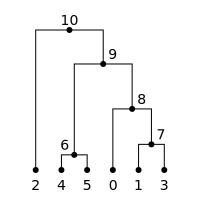

In [31]:
#take the first (only) tree and visualize
first_tree=singular_tree_seq.first()
SVG(first_tree.draw())

The `simulate()` function returns a standard `TreeSequence` object. Here there is only one tree because we have not provided a value for recombination_rate, which therefore defaults to zero. We can access the first (and only) tree in this sequence using `first()` method of a `TreeSequence` object.


We can also obtain the length of a branch joining a node to its parent using the `branch_length()` method; the total branch length in the tree is also stored in the `total_branch_length` attribute: 

In [32]:
node = 7
print("Branch length above node", node, "is", first_tree.branch_length(node))
print("Total branch length in tree is", first_tree.total_branch_length)

Branch length above node 7 is 4605.0710027482955
Total branch length in tree is 63385.43180380048


We can do the standard tree traverals using the ``nodes`` iterator:

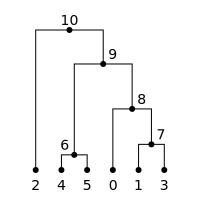

Default:	 [10, 2, 9, 6, 4, 5, 8, 0, 7, 1, 3]
Preorder:	 [10, 2, 9, 6, 4, 5, 8, 0, 7, 1, 3]
Inorder:	 [2, 10, 4, 6, 5, 9, 0, 8, 1, 7, 3]
Postorder:	 [2, 4, 5, 6, 0, 1, 3, 7, 8, 9, 10]


In [33]:
display(SVG(first_tree.draw()))
print("Default:\t", list(first_tree.nodes()))
print("Preorder:\t", list(first_tree.nodes(order="preorder")))
print("Inorder:\t", list(first_tree.nodes(order="inorder")))
print("Postorder:\t", list(first_tree.nodes(order="postorder")))

### Recombination
We are most often interested in simulating the history of our sample across large genomic regions under the influence of recombination. The msprime API is specifically designed to make this common requirement both easy and efficient. 

To model genomic sequences under the influence of recombination we have two parameters to the `simulate()` function. The length parameter specifies the length of the simulated sequence. The recombination_rate parameter specifies the rate of crossing over per unit of length per generation, and is zero by default.

Here, we simulate the trees across over a 10kb region with a recombination rate of 2×10−8 per base per generation, with a diploid effective population size of 1000:

--------------------
tree 0: interval = (0.0, 6173.258988692718)


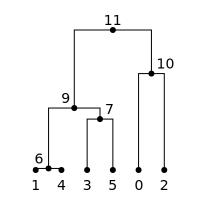

--------------------
tree 1: interval = (6173.258988692718, 10000.0)


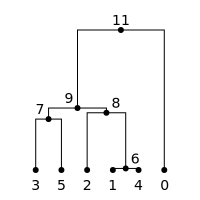

In [34]:
simple_tree_seq = msprime.simulate(
  sample_size=6, Ne=1000, length=1e4, recombination_rate=2e-8, random_seed=7)
for tree in simple_tree_seq.trees():
    print("-" * 20)
    print("tree {}: interval = {}".format(tree.index, tree.interval))
    display(SVG(tree.draw()))

As before, we use the `trees()` method to iterate over the trees in the sequence. For each tree we print out its index (i.e. its position in the sequence) and the interval the tree covers (i.e. the genomic coordinates which all share precisely this tree) using the index and interval attributes. Thus, the first tree covers the first 6kb of sequence, the second tree covers the remaining 4kb.

### Mutations
Mutations are generated in msprime by throwing mutations down on the branches of trees at a particular rate. The mutation rate for simulations is specified using the mutation_rate parameter of `simulate()`. For example, the following chunk simulates 50kb of nonrecombining sequence with a mutation rate of 1×10−8 per base per generation:

Num trees: 1
Mutation 0 @ position 1556.54 over node 9
Mutation 1 @ position 4485.17 over node 6
Mutation 2 @ position 9788.56 over node 6
Mutation 3 @ position 11759.03 over node 6
Mutation 4 @ position 11949.32 over node 6
Mutation 5 @ position 14321.77 over node 9
Mutation 6 @ position 31454.99 over node 6
Mutation 7 @ position 45125.69 over node 9
Mutation 8 @ position 49709.68 over node 6


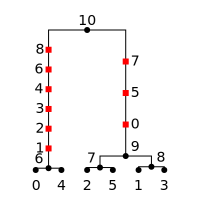

In [35]:
mut_tree_seq = msprime.simulate(
  sample_size=6, Ne=1000, length=50e3, mutation_rate=1e-8, random_seed=30)
print("Num trees:", mut_tree_seq.num_trees)
tree = mut_tree_seq.first()
for site in tree.sites():
    for mutation in site.mutations:
        print("Mutation {} @ position {:.2f} over node {}".format(
        mutation.id, site.position, mutation.node))
display(SVG(tree.draw()))

## Large simulations with $\texttt{msprime}$



One of the big advantages of msprime/tskit is that we can simulate and process genetic data on a very large scale. For example, here is a simulation of 100K human-like 10Mb chromosomes:

In [36]:
%%time
ts = msprime.simulate(
    sample_size=10**5, length=1e7, recombination_rate=1e-8, Ne=10**4, random_seed=20)

CPU times: user 5.64 s, sys: 120 ms, total: 5.76 s
Wall time: 6.17 s


In [37]:
print("Number of simulated trees: {}, Number of tips in each tree: {}".format(ts.num_trees, ts.num_samples))

Number of simulated trees: 45597, Number of tips in each tree: 100000


In [38]:
# Write the tree sequence to file.
ts.dump("data/large-ts-no-mutations.trees")

# Get the size
import os
print("File size = {}MiB".format(os.path.getsize("data/large-ts-no-mutations.trees") / 2**20))

File size = 18.185260772705078MiB


In [39]:
%%time
# Loading is fast
ts = msprime.load("data/large-ts-no-mutations.trees")

CPU times: user 19.9 ms, sys: 20 ms, total: 39.8 ms
Wall time: 40.4 ms


In [40]:
%%time
# So is iterating over all trees
total = 0  
for tree in ts.trees():
    total += tree.interval[1] - tree.interval[0] # Just to do *something* in the loop

print(total, ts.sequence_length)

10000000.0 10000000.0
CPU times: user 180 ms, sys: 4.75 ms, total: 185 ms
Wall time: 185 ms


In [41]:
%%time
# Insert a ridiculous number of mutations
mutated_ts = msprime.mutate(ts, rate=1e-6, random_seed=42) # deliberately high mutation rate

CPU times: user 13.2 s, sys: 1.33 s, total: 14.5 s
Wall time: 15 s


In [42]:
print("We just created {:,} variant sites!".format(mutated_ts.num_sites))

We just created 4,873,605 variant sites!


In [43]:
mutated_ts.dump("data/large-ts-mutations.trees")

print("Tree sequence size = {:.2f}MiB".format(os.path.getsize("data/large-ts-mutations.trees") / 2**20))
# PUT THIS IN GIGBYTES (TODO)

Tree sequence size = 194.80MiB


In [44]:
print("Tree Sequence as a set of Newick Files is {}GiB".format((len(ts.first().newick()) * ts.num_trees) / 1e9))

Tree Sequence as a set of Newick Files is 191.201489727GiB


In [45]:
print("Genotype matrix size: {:.2f}GiB".format(
    mutated_ts.num_sites * mutated_ts.num_samples / 2**30))

Genotype matrix size: 453.89GiB


# References and Documentation

$\texttt{msprime}$: <br>
Reference: Kelleher, J., Etheridge, A.M. and McVean, G., 2016. Efficient coalescent simulation and genealogical analysis for large sample sizes. PLoS computational biology, 12(5), p.e1004842.
<br>
Documentation: https://msprime.readthedocs.io/en/stable/index.html

$\texttt{SLiM}$: <br>
Reference: Haller, B.C., Galloway, J., Kelleher, J., Messer, P.W. and Ralph, P.L., 2018. Tree‐sequence recording in SL iM opens new horizons for forward‐time simulation of whole genomes. Molecular Ecology Resources.
<br>
Documentation: http://benhaller.com/slim/SLiM_Manual.pdf

$\texttt{tsinfer}$: <br>
Reference:  Kelleher, J., Wong, Y., Albers, P., Wohns, A.W. and McVean, G., 2018. Inferring the ancestry of everyone. bioRxiv, p.458067.
<br>
Documentation: https://tsinfer.readthedocs.io/en/latest/api.html?highlight=sample_data

Out of Africa Model used in section 3: <br>
Gutenkunst, R.N., Hernandez, R.D., Williamson, S.H. and Bustamante, C.D., 2009. Inferring the joint demographic history of multiple populations from multidimensional SNP frequency data. PLoS genetics, 5(10), p.e1000695.